This project began when I grew frustrated with rising resale ticket prices. Trying to guess whether you were better buying a ticket a week before a concert or holding out and hoping they dropped in price. So I decided I wanted to see if I could get to the bottom of it. 
The focus of this project will be on Madison Square Garden 

First up the Data. I knew stubhub, vivdseats etc had millions of data but I could not get access to any of it. Eventually I found a website called seatdata.io They had millions of data that could be accessed under their api , I however was reluctant to pay for access , So I signed up for their free trial and over the three days wrote a bot to manually download each days event for the venue 'Pier17'. Data was saved in Json format with the event date appended at end. '5secondsofsummerDDMMYY' for example.

In [1]:
import os
import pandas as pd
from datetime import datetime
import json
import numpy as np
# --------------------------------------------
# 1. Load JSON Data & Extract Event Metadata
# --------------------------------------------
def load_json_events(base_path="../data/raw"):
    all_events = []
        
    for file_name in os.listdir(base_path):
        if not file_name.lower().endswith(".json"): continue
        json_file = os.path.join(base_path, file_name)
        file_base, _ = os.path.splitext(file_name)
        
        if os.path.exists(json_file):
            # Extract event date and name from filename
            event_date_str = file_base[-6:]
            event_name = file_base[:-6]
            event_date = datetime.strptime(event_date_str, "%y%m%d")
            
            # Load JSON data
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    listings = json.load(f)
            except UnicodeDecodeError:
                try:
                    with open(json_file, 'r', encoding='latin-1') as f:
                        listings = json.load(f)
                except Exception as e:
                    print(f"Error reading {json_file}: {str(e)}")
                    continue
            
            df = pd.DataFrame(listings)
            df["event_date"] = event_date
            df["event_name"] = event_name
            all_events.append(df)

    df_p17 = pd.concat(all_events, ignore_index=True)
    return  df_p17

# Load all data
df = load_json_events()
print("\nDataFrame Info:")
print(df.info())
print("\nDataFrame Shape (rows, columns):")
print(df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

# Save to CSV for quick loading later
print("\nSaving to CSV...")
df.to_csv("p17processed_data.csv", index=False)
print("Data saved to p17processed_data.csv")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32273 entries, 0 to 32272
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   32273 non-null  object        
 1   zone        32273 non-null  object        
 2   section     32273 non-null  object        
 3   row         32273 non-null  object        
 4   quantity    32273 non-null  float64       
 5   price       32273 non-null  float64       
 6   event_date  32273 non-null  datetime64[ns]
 7   event_name  32273 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 2.0+ MB
None

DataFrame Shape (rows, columns):
(32273, 8)

First 5 rows:
             timestamp zone                       section  row  quantity  \
0  07-12-22 / 12:52 PM   GA       Floor General Admission  535       2.0   
1  07-11-22 / 02:44 PM   GA       Floor General Admission            1.0   
2  07-10-22 / 06:26 PM   GA    

We extract the date and add it as a column and we can also see the data types are objects and floats with the exception of the datetime we parsed.

In [4]:
import pandas as pd
import logging
from pathlib import Path
from typing import Optional
from datetime import datetime
import pytz
# Define EST timezone
est = pytz.timezone('America/New_York')

# Convert numeric columns
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce') 
df['row'] = pd.to_numeric(df['row'], errors='coerce')

# Convert listing timestamp to datetime and localize to EST

df['listing_time'] = pd.to_datetime(df['timestamp'], format="%m-%d-%y / %I:%M %p")
df['listing_time'] = df['listing_time'].dt.tz_localize(est, ambiguous='NaT')

# Ensure event_date is also in EST  
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')
df['event_date'] = df['event_date'].dt.tz_localize(est)

# Check for NaT/NaN values in datetime columns
print("\nMissing values in listing_time:")
print(df['listing_time'].isna().sum())
print("\nMissing values in event_date:") 
print(df['event_date'].isna().sum())

# Calculate days between listing and event
time_diff = (df["event_date"] - df["listing_time"]).dt.total_seconds()

# Convert to days and round down 
df["days_until_event"] = (time_diff / (24 * 3600)).astype(int)

print("\nMissing values in days_until_event:")
print(df['days_until_event'].isna().sum())




Missing values in listing_time:
0

Missing values in event_date:
0

Missing values in days_until_event:
0


The days have been brought in now time to inspect them.

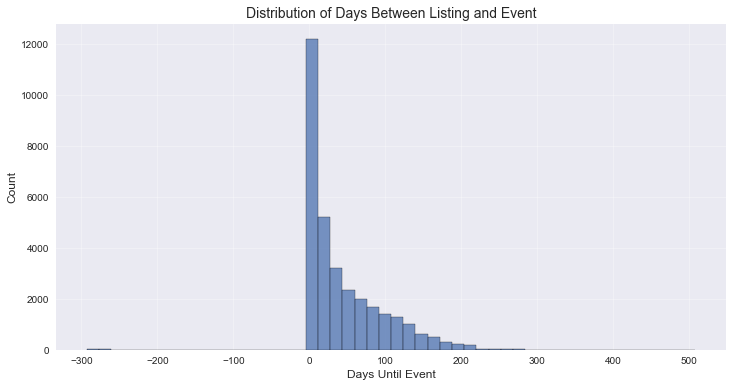


Summary statistics for days until event:
count    32273.000000
mean        42.837325
std         51.797193
min       -293.000000
25%          4.000000
50%         22.000000
75%         68.000000
max        508.000000
Name: days_until_event, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
plt.style.use('seaborn')

# Create figure and axis
plt.figure(figsize=(12, 6))

# Create histogram of days until event
sns.histplot(data=df, x='days_until_event', bins=50)

# Customize the plot
plt.title('Distribution of Days Between Listing and Event', fontsize=14)
plt.xlabel('Days Until Event', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

# Print some basic statistics
print("\nSummary statistics for days until event:")
print(df['days_until_event'].describe())


In [6]:
# Find and display rows where days_until_event is negative
negative_days = df[df['days_until_event'] < 0]

print("\nRows with negative days until event:")
print(f"Number of rows: {len(negative_days)}")
print("\nSample of these rows:")
print(negative_days[['event_name', 'listing_time', 'event_date', 'days_until_event','quantity','price','row']].head())

# Basic statistics of negative cases
print("\nStatistics for negative days:")
print(negative_days['days_until_event'].describe())



Rows with negative days until event:
Number of rows: 84

Sample of these rows:
                                      event_name              listing_time  \
6810  CitySessions50ForeverftWaleandSpecialGuest 2023-07-21 00:34:00-04:00   
6811  CitySessions50ForeverftWaleandSpecialGuest 2023-07-21 00:34:00-04:00   
6812  CitySessions50ForeverftWaleandSpecialGuest 2023-07-21 00:34:00-04:00   
6813  CitySessions50ForeverftWaleandSpecialGuest 2023-07-21 00:34:00-04:00   
6814  CitySessions50ForeverftWaleandSpecialGuest 2023-07-21 00:34:00-04:00   

                    event_date  days_until_event  quantity   price  row  
6810 2023-07-20 00:00:00-04:00                -1       1.0   76.50  NaN  
6811 2023-07-20 00:00:00-04:00                -1       1.0   83.42  NaN  
6812 2023-07-20 00:00:00-04:00                -1       1.0   75.15  NaN  
6813 2023-07-20 00:00:00-04:00                -1       2.0   63.00  NaN  
6814 2023-07-20 00:00:00-04:00                -1       2.0  166.95  NaN  

Statis

We see some of our data is wrong and the listings have been put for sale after the event.
We will remove these days.

In [7]:
# Remove rows where days_until_event is negative
df = df[df['days_until_event'] >= 0]

# Print the shape of the dataframe after removal
print(f"\nShape of dataframe after removing negative days: {df.shape}")



Shape of dataframe after removing negative days: (32189, 10)


In [8]:
# Data Quality & Integrity Checks

# 1. Check for missing values in critical columns
print("\nMissing values in critical columns:")
print(df[['quantity', 'price', 'days_until_event', 'listing_time', 'event_date']].isnull().sum())

# 2. Temporal consistency check
temporal_issues = df[df['listing_time'] > df['event_date']]
print("\nNumber of listings with temporal inconsistency (listing after event):", len(temporal_issues))

# 3. Check for negative values
print("\nNegative value checks:")
print(f"Negative prices: {len(df[df['price'] < 0])}")
print(f"Negative quantities: {len(df[df['quantity'] < 0])}")
print(f"Negative days until event: {len(df[df['days_until_event'] < 0])}")  # Should be 0 after previous cleanup

# 4. Check for duplicate listings
# Check for duplicate listings based on key attributes
# Don't truncate column width
pd.set_option('display.max_colwidth', None)
duplicates = df[df.duplicated()]


print(f"Number of duplicate listings: {len(duplicates)}")


# Display top 20 duplicate listings with selected columns
print("\nTop 20 duplicate listings (selected columns):")
print(duplicates[['quantity', 'event_name', 'price']].sort_values('event_name').head(20))


# Summary of data quality issues
print("\nData Quality Summary:")
print("-" * 50)
total_rows = len(df)
print(f"Total rows: {total_rows}")
print(f"Missing values in critical columns: {df[['quantity', 'price', 'days_until_event']].isnull().sum().sum()}")
print(f"Temporal inconsistencies: {len(temporal_issues)}")
print(f"Rows with negative values: {len(df[(df['price'] < 0) | (df['quantity'] < 0) | (df['days_until_event'] < 0)])}")
print(f"Duplicate listings: {len(duplicates)}")




Missing values in critical columns:
quantity            0
price               0
days_until_event    0
listing_time        0
event_date          0
dtype: int64

Number of listings with temporal inconsistency (listing after event): 2759

Negative value checks:
Negative prices: 0
Negative quantities: 0
Negative days until event: 0
Number of duplicate listings: 396

Top 20 duplicate listings (selected columns):
      quantity              event_name   price
85         1.0        5SecondsofSummer   57.99
798        1.0              AllTimeLow   63.00
829        2.0              AllTimeLow  130.09
835        1.0              AllTimeLow  124.95
901        2.0              AllTimeLow  256.01
902        2.0              AllTimeLow  256.60
1092       0.0      AmylandTheSniffers  118.00
1821       2.0       AnEveningWithCAKE   90.00
1793       1.0       AnEveningWithCAKE   88.27
1664       2.0       AnEveningWithCAKE   92.15
1271       1.0       AnEveningWithCAKE   76.50
1323       1.0       AnE

In [9]:
# Check for and remove tickets with 0 or negative quantity
invalid_quantity_mask = df['quantity'] <= 0
num_invalid_quantity = invalid_quantity_mask.sum()

if num_invalid_quantity > 0:
    print(f"\nFound {num_invalid_quantity} tickets with invalid (0 or negative) quantity")
    print("\nExample invalid quantity tickets:")
    print(df[invalid_quantity_mask][['quantity', 'event_name', 'price']].head())
    
    # Remove invalid quantity tickets
    df = df[~invalid_quantity_mask]
    print(f"\nRemoved {num_invalid_quantity} invalid quantity tickets")
    print(f"Rows remaining in dataset: {len(df)}")
else:
    print("\nNo tickets found with 0 or negative quantity")
# Remove tickets with invalid quantities
df = df[df['quantity'] > 0]
print(f"\nDataset size after removing invalid quantities: {len(df)}")
# Check for and remove tickets with 0 or negative price
invalid_price_mask = df['price'] <= 0
num_invalid_price = invalid_price_mask.sum()

if num_invalid_price > 0:
    print(f"\nFound {num_invalid_price} tickets with invalid (0 or negative) price")
    print("\nExample invalid price tickets:")
    print(df[invalid_price_mask][['quantity', 'event_name', 'price']].head())
    
    # Remove invalid price tickets
    df = df[~invalid_price_mask]
    print(f"\nRemoved {num_invalid_price} invalid price tickets")
    print(f"Rows remaining in dataset: {len(df)}")
else:
    print("\nNo tickets found with 0 or negative price")

# Remove tickets with invalid prices
df = df[df['price'] > 0]
print(f"\nDataset size after removing invalid prices: {len(df)}")



Found 306 tickets with invalid (0 or negative) quantity

Example invalid quantity tickets:
      quantity          event_name  price
1029       0.0  AmylandTheSniffers  179.0
1031       0.0  AmylandTheSniffers  245.0
1032       0.0  AmylandTheSniffers  145.0
1033       0.0  AmylandTheSniffers  179.0
1034       0.0  AmylandTheSniffers  149.0

Removed 306 invalid quantity tickets
Rows remaining in dataset: 31883

Dataset size after removing invalid quantities: 31883

No tickets found with 0 or negative price

Dataset size after removing invalid prices: 31883


In [10]:
dupes = df[df.duplicated(keep=False)]
print(dupes.head(10))  # show a few flagged as duplicates

# Check which "duplicate" rows are actually NOT equal to each other
print("\nChecking equality of duplicate rows:")
for i in range(0, len(dupes) - 1):
    row1 = dupes.iloc[i]
    row2 = dupes.iloc[i+1]
    if not row1.equals(row2):
        print(f"Row {i} and Row {i+1} are NOT equal:")
        print(row1)
        print(row2)
        print("-" * 40)

               timestamp               zone                  section  row  \
84   02-12-22 / 09:46 PM                 GA  Floor General Admission  NaN   
85   02-12-22 / 09:46 PM                 GA  Floor General Admission  NaN   
796  09-10-23 / 09:16 PM  General Admission        General Admission  NaN   
798  09-10-23 / 09:16 PM  General Admission        General Admission  NaN   
828  09-06-23 / 08:40 PM  General Admission        General Admission  NaN   
829  09-06-23 / 08:40 PM  General Admission        General Admission  NaN   
834  09-06-23 / 08:40 PM  General Admission        General Admission  NaN   
835  09-06-23 / 08:40 PM  General Admission        General Admission  NaN   
899  08-21-23 / 03:21 PM  General Admission        General Admission  NaN   
900  08-21-23 / 03:21 PM  General Admission        General Admission  NaN   

     quantity   price                event_date        event_name  \
84        1.0   57.99 2022-07-12 00:00:00-04:00  5SecondsofSummer   
85        1.0 

In [11]:
# Remove duplicate rows from the main dataframe
df_no_dupes = df.drop_duplicates()

# Print summary of duplicates removed
num_dupes_removed = len(df) - len(df_no_dupes)
print(f"\nNumber of duplicate rows removed: {num_dupes_removed}")
print(f"Rows in original dataset: {len(df)}")
print(f"Rows after removing duplicates: {len(df_no_dupes)}")

# Replace original dataframe with deduplicated version
df = df_no_dupes



Number of duplicate rows removed: 394
Rows in original dataset: 31883
Rows after removing duplicates: 31489


After further inspection that they are indeed duplicates. 396 Rows were removed from the dataset.

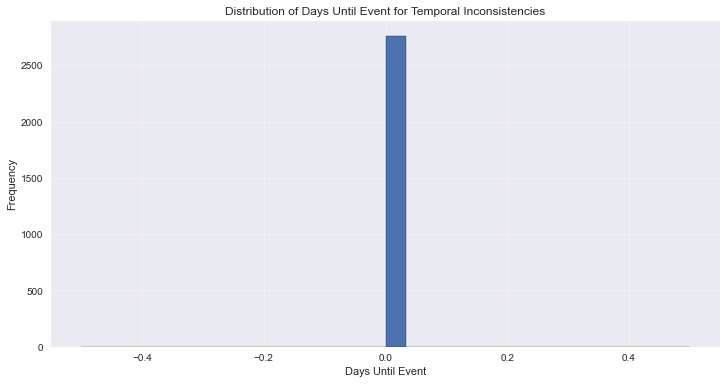


Summary statistics for days_until_event in temporal inconsistencies:
count    2759.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: days_until_event, dtype: float64


In [12]:
# Analyze temporal inconsistencies
if len(temporal_issues) > 0:
    plt.figure(figsize=(12,6))
    plt.hist(temporal_issues['days_until_event'], bins=30, edgecolor='black')
    plt.title('Distribution of Days Until Event for Temporal Inconsistencies')
    plt.xlabel('Days Until Event') 
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\nSummary statistics for days_until_event in temporal inconsistencies:")
    print(temporal_issues['days_until_event'].describe())


The rows with temporal issues. All seem to be listings made on the day of. This is valid as they could have been listed in the morning for an evening show.

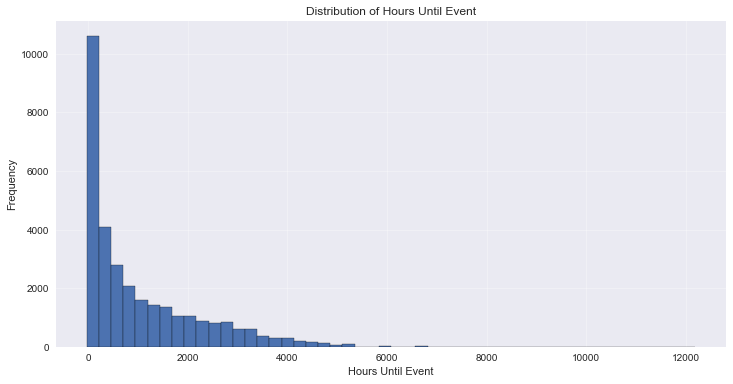

In [13]:
# Create hours until event column based on timestamp difference
# Convert both columns to datetime if not already
df['hours_until_event'] = (df['event_date'] - df['listing_time']).dt.total_seconds() / 3600
# Plot distribution of hours until event
plt.figure(figsize=(12,6))
plt.hist(df['hours_until_event'], bins=50, edgecolor='black')
plt.title('Distribution of Hours Until Event')
plt.xlabel('Hours Until Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()



We unforunately do not have access to start time. But this might help us identify times in the night before the event if buying at mid day or the night before make a difference.

Now time to investigate the Target Variable (Price).

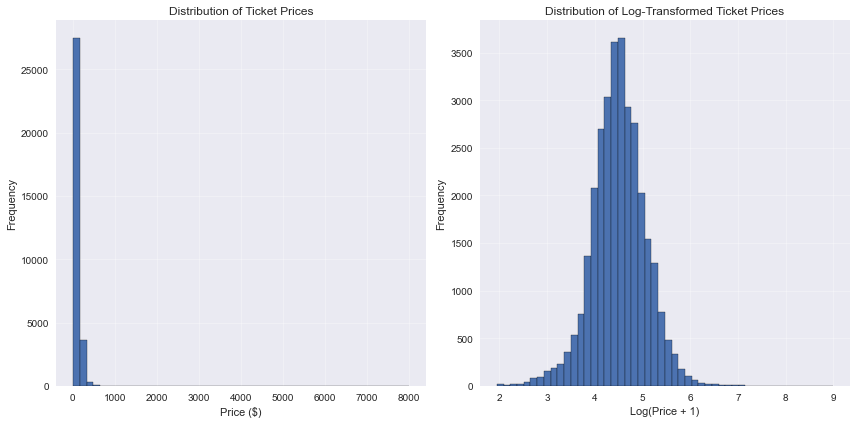

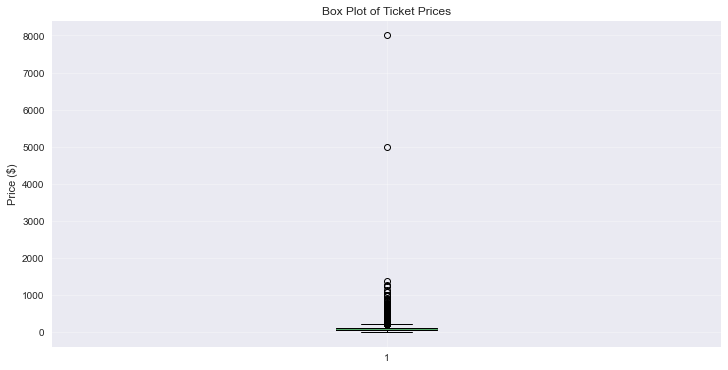


Summary statistics for ticket prices:
count    31489.000000
mean       104.706691
std         85.703578
min          6.000000
25%         63.000000
50%         88.960000
75%        126.130000
max       8000.000000
Name: price, dtype: float64

Number of price outliers: 1571

Sample of extreme prices:
         price                event_date                 event_name
15448  8000.00 2021-09-14 00:00:00-04:00            MachineGunKelly
30362  5000.00 2022-06-04 00:00:00-04:00                   VanceJoy
17867  1370.03 2023-08-03 00:00:00-04:00                       Niki
18837  1262.47 2024-07-26 00:00:00-04:00  OARwithFitzandtheTantrums
9047   1250.00 2022-08-11 00:00:00-04:00  ElvisCostelloTheImposters


In [14]:
# Analyze price distribution
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(df['price'], bins=50, edgecolor='black')
plt.title('Distribution of Ticket Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Log transform for better visualization
plt.subplot(1,2,2)
plt.hist(np.log1p(df['price']), bins=50, edgecolor='black')
plt.title('Distribution of Log-Transformed Ticket Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Box plot
plt.figure(figsize=(12,6))
plt.boxplot(df['price'])
plt.title('Box Plot of Ticket Prices')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate summary statistics
print("\nSummary statistics for ticket prices:")
print(df['price'].describe())

# Identify potential outliers
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[
    (df['price'] < lower_bound) | 
    (df['price'] > upper_bound)
]

print("\nNumber of price outliers:", len(outliers))
print("\nSample of extreme prices:")
print(outliers[['price', 'event_date', 'event_name']].sort_values('price', ascending=False).head())


We can see we have a few extreme outliers. As this is sales listings data , I cannot be sure if these tickets ever sold . Lets inspect the other prices for these events and if they are extreme then remove them.

In [15]:
# Check prices for specific events
events_to_check = ['MachineGunKelly', 'VanceJoy', 'Niki', 'OARwithFitzandtheTantrums', 'ElvisCostelloTheImposters']

print("\nTop 5 highest prices for selected events:")
print("-" * 80)

for event in events_to_check:
    print(f"\n{event}:")
    event_prices = df[df['event_name'] == event][['price', 'section', 'event_name']].sort_values('price', ascending=False).head()
    if len(event_prices) > 0:
        print(event_prices)
    else:
        print("No data found for this event")



Top 5 highest prices for selected events:
--------------------------------------------------------------------------------

MachineGunKelly:
         price                       section       event_name
15448  8000.00  Green Zone General Admission  MachineGunKelly
15387  1080.00  Green Zone General Admission  MachineGunKelly
15446   998.75  Green Zone General Admission  MachineGunKelly
15354   995.00  Green Zone General Admission  MachineGunKelly
15349   965.00  Green Zone General Admission  MachineGunKelly

VanceJoy:
         price                       section event_name
30362  5000.00       Floor General Admission   VanceJoy
30494  1128.87  Green Zone General Admission   VanceJoy
30446   882.30  Green Zone General Admission   VanceJoy
30471   873.48  Green Zone General Admission   VanceJoy
30431   705.84  Green Zone General Admission   VanceJoy

Niki:
         price            section event_name
17867  1370.03               Zone       Niki
18046   143.67  General Admission       Ni

In [16]:
# Print summary statistics for each artist
print("\nSummary statistics for each artist:")
print("-" * 80)

for event in events_to_check:
    print(f"\n{event}:")
    event_stats = df[df['event_name'] == event]['price'].describe()
    if len(event_stats) > 0:
        print(event_stats)
    else:
        print("No data found for this event")




Summary statistics for each artist:
--------------------------------------------------------------------------------

MachineGunKelly:
count     147.000000
mean      435.161837
std       652.879513
min       100.000000
25%       275.000000
50%       339.000000
75%       406.250000
max      8000.000000
Name: price, dtype: float64

VanceJoy:
count     214.000000
mean      235.636822
std       351.594391
min        80.000000
25%       154.500000
50%       164.645000
75%       238.175000
max      5000.000000
Name: price, dtype: float64

Niki:
count     280.000000
mean       53.892964
std        81.770689
min        15.360000
25%        34.870000
50%        44.895000
75%        54.095000
max      1370.030000
Name: price, dtype: float64

OARwithFitzandtheTantrums:
count     531.000000
mean      117.074802
std        72.211303
min        54.000000
25%        82.460000
50%        97.870000
75%       134.440000
max      1262.470000
Name: price, dtype: float64

ElvisCostelloTheImposters:
count 

In [17]:
# Get list of all unique events
all_events = df['event_name'].unique()

# Check lowest prices for all events
print("\nTop 5 lowest prices for all events:")
print("-" * 80)

for event in all_events:
    print(f"\n{event}:")
    event_prices = df[df['event_name'] == event][['price', 'section', 'event_name']].sort_values('price').head()
    print(event_prices)

# Look for any suspiciously low prices (e.g. under $10) across all events
print("\nTickets priced under $10 for any event:")
print("-" * 80)
very_low_prices = df[df['price'] < 10][['event_name', 'price', 'section']]
if len(very_low_prices) > 0:
    print(very_low_prices)
else:
    print("No tickets found under $10")

# Get price ranges and quartiles for all events to check if low prices are outliers
print("\nPrice distribution statistics for all events:")
print("-" * 80)
for event in all_events:
    event_data = df[df['event_name'] == event]['price']
    q1 = event_data.quantile(0.25)
    q3 = event_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    
    print(f"\n{event}:")
    print(f"Price range: ${event_data.min():.2f} - ${event_data.max():.2f}")
    print(f"IQR: ${iqr:.2f}")
    print(f"Lower bound for outliers: ${lower_bound:.2f}")
    potential_outliers = event_data[event_data < lower_bound]
    if len(potential_outliers) > 0:
        print(f"Number of potential low price outliers: {len(potential_outliers)}")
        print("Potential outlier prices:")
        print(potential_outliers.sort_values())




Top 5 lowest prices for all events:
--------------------------------------------------------------------------------

5SecondsofSummer:
     price                  section        event_name
100  30.85  Floor General Admission  5SecondsofSummer
97   30.85  Floor General Admission  5SecondsofSummer
95   30.85  Floor General Admission  5SecondsofSummer
99   30.92  Floor General Admission  5SecondsofSummer
98   31.00  Floor General Admission  5SecondsofSummer

ADaytoRemember:
     price                       section      event_name
445  15.00  Green Zone General Admission  ADaytoRemember
447  16.48  Green Zone General Admission  ADaytoRemember
446  17.40       Floor General Admission  ADaytoRemember
480  35.00       Floor General Admission  ADaytoRemember
448  39.89       Floor General Admission  ADaytoRemember

AlecBenjaminTheCommentaryTourwithSpGuestClaireRosinkranz:
     price                       section  \
603  26.10  Green Zone General Admission   
619  27.00       Floor General Ad

We have seen some crazy outliers, Which is to be expected with ticket scalpers but as we are focused on the best time to purchase a ticket these extreme prices that only someone desperate would pay are not the focus of this project. So we will use the 1.5 * Inter Quartile rule.

In [18]:
# Define function to remove price outliers using IQR method
def remove_price_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return group[(group['price'] >= lower) & (group['price'] <= upper)]

# Apply outlier removal per event group
df_clean = df.groupby('event_name', group_keys=False).apply(remove_price_outliers)

# Print summary of records removed
print("\nOutlier removal summary:")
print("-" * 80)
print(f"Original records: {len(df)}")
print(f"Records after removing outliers: {len(df_clean)}")
print(f"Number of outliers removed: {len(df) - len(df_clean)}")



Outlier removal summary:
--------------------------------------------------------------------------------
Original records: 31489
Records after removing outliers: 29280
Number of outliers removed: 2209


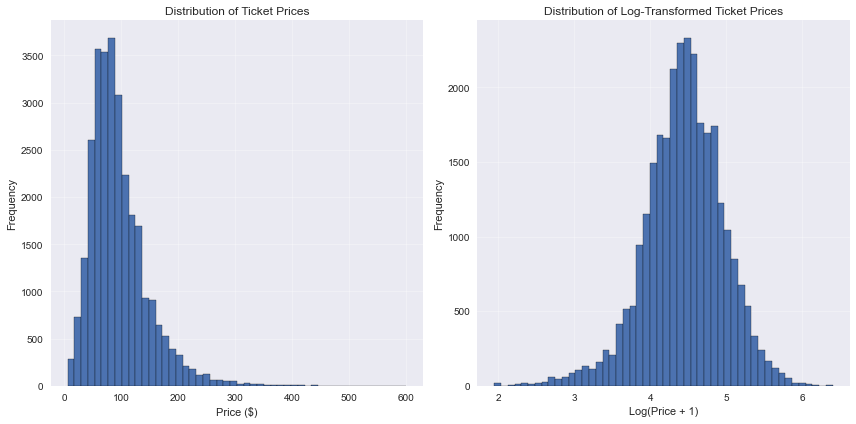

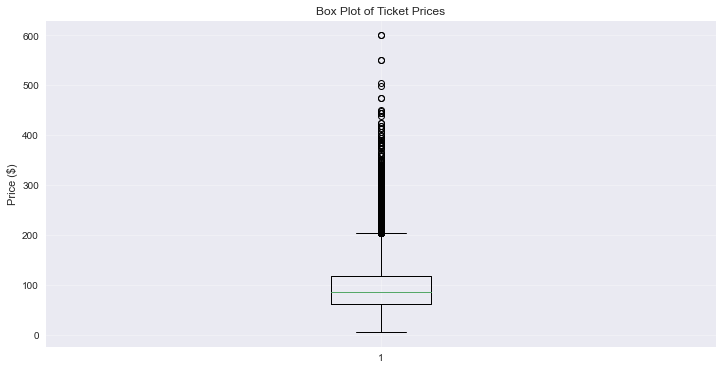


Summary statistics for ticket prices:
count    29280.000000
mean        95.762358
std         50.877987
min          6.000000
25%         61.290000
50%         85.500000
75%        118.630000
max        600.000000
Name: price, dtype: float64

Number of price outliers: 1070

Sample of extreme prices:
       price                event_date       event_name
15406  600.0 2021-09-14 00:00:00-04:00  MachineGunKelly
15400  600.0 2021-09-14 00:00:00-04:00  MachineGunKelly
15360  549.9 2021-09-14 00:00:00-04:00  MachineGunKelly
15362  549.9 2021-09-14 00:00:00-04:00  MachineGunKelly
15428  504.0 2021-09-14 00:00:00-04:00  MachineGunKelly


In [19]:
# Analyze price distribution
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(df_clean['price'], bins=50, edgecolor='black')
plt.title('Distribution of Ticket Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Log transform for better visualization
plt.subplot(1,2,2)
plt.hist(np.log1p(df_clean['price']), bins=50, edgecolor='black')
plt.title('Distribution of Log-Transformed Ticket Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Box plot
plt.figure(figsize=(12,6))
plt.boxplot(df_clean['price'])
plt.title('Box Plot of Ticket Prices')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate summary statistics
print("\nSummary statistics for ticket prices:")
print(df_clean['price'].describe())

# Identify potential outliers
q1 = df_clean['price'].quantile(0.25)
q3 = df_clean['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_clean[
    (df_clean['price'] < lower_bound) | 
    (df_clean['price'] > upper_bound)
]

print("\nNumber of price outliers:", len(outliers))
print("\nSample of extreme prices:")
print(outliers[['price', 'event_date', 'event_name']].sort_values('price', ascending=False).head())


We can see the data is right skewed with most tickets ranging between 25>150. A long tail shows some tickets still reach 600 which we can see is machine gun kelly who we identified in the extreme prices earlier. Perhaps he was just really popular.
When prices are log transformed is shows a roughly normal distribution, This is useful as this should stabilse variance and should help us with modelling later.
We can see the IQR is now between 61.62 and 118.7 instead of 63.0 and 126.61.
The data contains a central cluster of simiarily priced events and a small proportion of highly priced outliers indicating possible premium seating or high demand events.

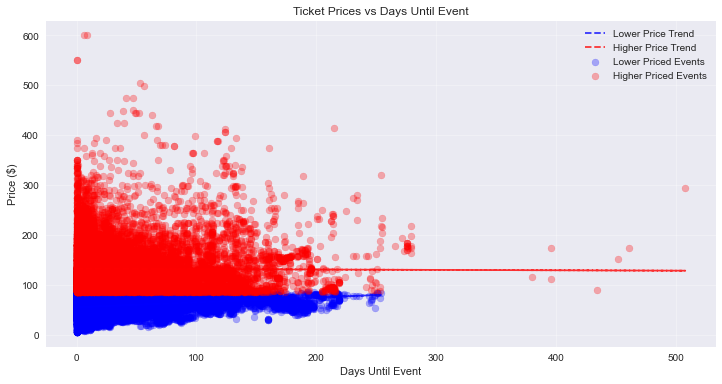


Correlation between days until event and price:
All events: 0.068
Higher priced events: -0.008
Lower priced events: 0.281


In [20]:


# Create scatter plot
plt.figure(figsize=(12,6))

# Split into high/low demand based on median price
median_price = df_clean['price'].median()
high_demand = df_clean[df_clean['price'] > median_price]
low_demand = df_clean[df_clean['price'] <= median_price]

# Plot points
plt.scatter(low_demand['days_until_event'], low_demand['price'], 
           alpha=0.3, label='Lower Priced Events', color='blue')
plt.scatter(high_demand['days_until_event'], high_demand['price'],
           alpha=0.3, label='Higher Priced Events', color='red')

# Add trendlines
z1 = np.polyfit(low_demand['days_until_event'], low_demand['price'], 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(high_demand['days_until_event'], high_demand['price'], 1)
p2 = np.poly1d(z2)

plt.plot(low_demand['days_until_event'], p1(low_demand['days_until_event']), 
         "b--", alpha=0.8, label='Lower Price Trend')
plt.plot(high_demand['days_until_event'], p2(high_demand['days_until_event']), 
         "r--", alpha=0.8, label='Higher Price Trend')

plt.title('Ticket Prices vs Days Until Event')
plt.xlabel('Days Until Event')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print correlation statistics
print("\nCorrelation between days until event and price:")
print("All events:", round(df_clean['days_until_event'].corr(df_clean['price']), 3))
print("Higher priced events:", round(high_demand['days_until_event'].corr(high_demand['price']), 3))
print("Lower priced events:", round(low_demand['days_until_event'].corr(low_demand['price']), 3))



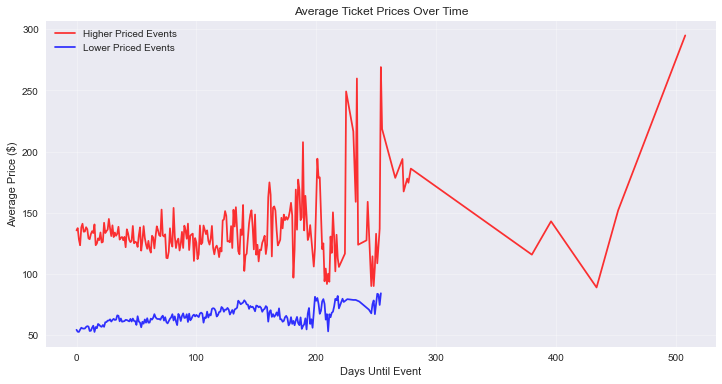

In [21]:
# Create line plot
plt.figure(figsize=(12,6))

# Calculate mean prices by days until event for each group
high_demand_means = high_demand.groupby('days_until_event')['price'].mean()
low_demand_means = low_demand.groupby('days_until_event')['price'].mean()

# Plot lines
plt.plot(high_demand_means.index, high_demand_means.values, 
         'r-', alpha=0.8, label='Higher Priced Events')
plt.plot(low_demand_means.index, low_demand_means.values,
         'b-', alpha=0.8, label='Lower Priced Events')

plt.title('Average Ticket Prices Over Time')
plt.xlabel('Days Until Event') 
plt.ylabel('Average Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


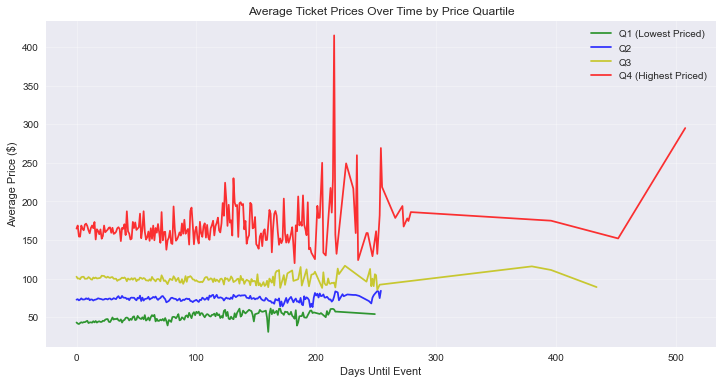

In [22]:
# Create line plot for all IQR groups
plt.figure(figsize=(12,6))
# Calculate quartile values for price
q1_price = df_clean['price'].quantile(0.25)
q2_price = df_clean['price'].quantile(0.5) 
q3_price = df_clean['price'].quantile(0.75)

# Split events into quartile groups
q1_events = df_clean[df_clean['price'] <= q1_price]
q2_events = df_clean[(df_clean['price'] > q1_price) & (df_clean['price'] <= q2_price)]
q3_events = df_clean[(df_clean['price'] > q2_price) & (df_clean['price'] <= q3_price)]
q4_events = df_clean[df_clean['price'] > q3_price]

# Calculate mean prices by days until event for each IQR group
q1_means = q1_events.groupby('days_until_event')['price'].mean()
q2_means = q2_events.groupby('days_until_event')['price'].mean()
q3_means = q3_events.groupby('days_until_event')['price'].mean()
q4_means = q4_events.groupby('days_until_event')['price'].mean()

# Plot lines for each quartile
plt.plot(q1_means.index, q1_means.values, 
         'g-', alpha=0.8, label='Q1 (Lowest Priced)')
plt.plot(q2_means.index, q2_means.values,
         'b-', alpha=0.8, label='Q2')
plt.plot(q3_means.index, q3_means.values,
         'y-', alpha=0.8, label='Q3')
plt.plot(q4_means.index, q4_means.values,
         'r-', alpha=0.8, label='Q4 (Highest Priced)')

plt.title('Average Ticket Prices Over Time by Price Quartile')
plt.xlabel('Days Until Event')
plt.ylabel('Average Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Overall Trends:
Q1 (Green): Represents the lowest 25% of ticket prices. Prices are consistently low, fluctuating slightly around $50-$75 throughout the timeline, showing minimal variation with time.
Q2 (Blue): The second quartile shows a similar pattern to Q1, with prices slightly higher, averaging around $75-$100. There’s a slight upward trend toward the event date, peaking near $100.
Q3 (Yellow): The third quartile starts around $100, shows moderate fluctuations, and trends downward slightly to around $75-$90 by the event date, with a dip around 400 days.
Q4 (Red): The highest-priced quartile (top 25%) exhibits significant volatility. Prices start around $150, spike dramatically to $400 around 250-300 days, then drop sharply to around $100 by 400 days. Toward the event (0-100 days), prices rise again to about $200.

Volatility:
Q4 shows extreme volatility, especially between 200 and 300 days, with a sharp peak that suggests a potential outlier or a specific high-demand event. This volatility could indicate market dynamics like scalping, limited ticket releases, or high demand for premium events.
Q1, Q2, and Q3 are relatively stable, with smoother trends and smaller price fluctuations, indicating more predictable pricing for lower and mid-tier events.
Price Behavior Near Event:
As the event date approaches (0-100 days), Q4 prices increase, suggesting a last-minute demand surge for high-end tickets. Conversely, Q3 prices dip slightly, while Q1 and Q2 remain stable or rise modestly, indicating less price sensitivity for lower tiers.

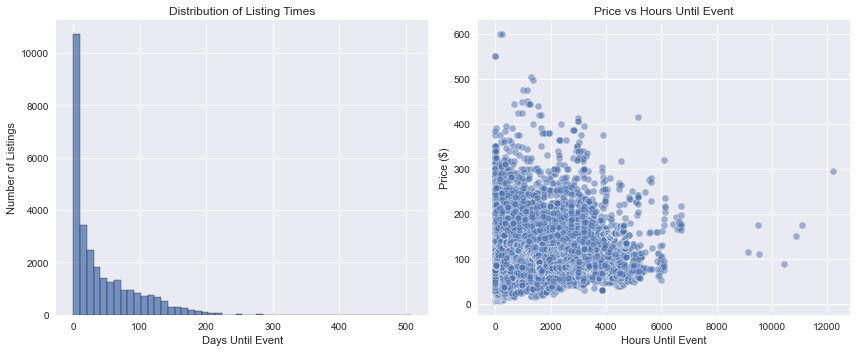


Average prices by listing timing:
0-1 days before: $89.43
1-7 days before: $88.89
7-30 days before: $96.73
More than 30 days before: $99.43


In [23]:


# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of listing times
sns.histplot(data=df_clean, x='days_until_event', bins=50, ax=ax1)
ax1.set_title('Distribution of Listing Times')
ax1.set_xlabel('Days Until Event')
ax1.set_ylabel('Number of Listings')

# Plot 2: Hours until event vs price
sns.scatterplot(data=df_clean, x='hours_until_event', y='price', alpha=0.5, ax=ax2)
ax2.set_title('Price vs Hours Until Event')
ax2.set_xlabel('Hours Until Event')
ax2.set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

# Calculate average prices for different time windows
time_windows = [
    (0, 24),     # Last day
    (24, 168),   # Last week
    (168, 720),  # Last month
    (720, float('inf'))  # More than a month
]

print("\nAverage prices by listing timing:")
for start, end in time_windows:
    mask = (df_clean['hours_until_event'] >= start) & (df_clean['hours_until_event'] < end)
    avg_price = df_clean[mask]['price'].mean()
    if end == float('inf'):
        print(f"More than 30 days before: ${avg_price:.2f}")
    else:
        print(f"{start/24:.0f}-{end/24:.0f} days before: ${avg_price:.2f}")


We can see that prices tend to go down as the concert approaches with a last minute spike the day before/day of.


Top 10 events by number of listings:
PixiesandModestMouse: 838 listings, avg price: $103.89
Macklemore: 796 listings, avg price: $125.61
StillWoozy: 716 listings, avg price: $116.78
TheUsedandPierceTheVeil: 710 listings, avg price: $137.89
YoungtheGiantwithMilkyChance: 696 listings, avg price: $139.63
TateMcRae: 694 listings, avg price: $98.60
Jvke: 628 listings, avg price: $58.91
JoeRussosAlmostDead: 619 listings, avg price: $165.32
BebeRexha: 608 listings, avg price: $49.10
ToveLoDirtFemmeTourWithSpecialGuestUpsahl: 587 listings, avg price: $105.21


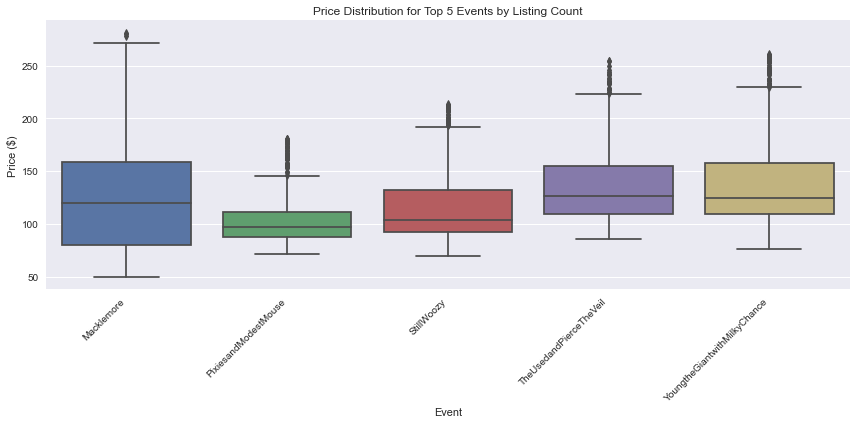

In [24]:
# Get top 10 events by listing count
top_10_by_count = df_clean['event_name'].value_counts().head(10)
print("\nTop 10 events by number of listings:")
for event, count in top_10_by_count.items():
    avg_price = df_clean[df_clean['event_name'] == event]['price'].mean()
    print(f"{event}: {count} listings, avg price: ${avg_price:.2f}")

# Get top 5 events by listing count for boxplot
top_5_events = df_clean['event_name'].value_counts().head(5).index

# Create boxplot for price distribution of top 5 events
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[df_clean['event_name'].isin(top_5_events)], 
            x='event_name', 
            y='price')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution for Top 5 Events by Listing Count')
plt.xlabel('Event')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()


Most events have median prices between $75 and $125, indicating that the bulk of ticket prices are relatively affordable.
The IQR for all events is fairly narrow (typically $20-$50), suggesting that the majority of ticket prices are clustered closely together.
All events have outliers extending up to $250-$275, indicating a small number of premium or scalped tickets significantly above the typical price range.

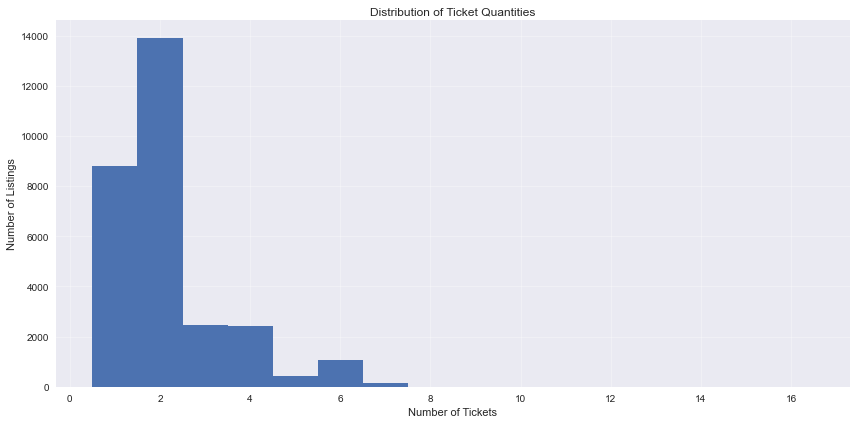


Quantity Statistics:
count    29280.000000
mean         2.169433
std          1.249918
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         16.000000
Name: quantity, dtype: float64


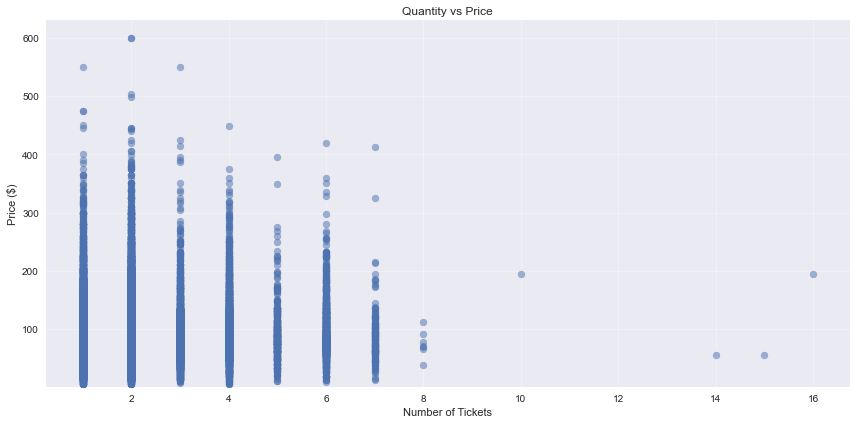


Correlation between quantity and price: 0.019

Average price by quantity:
1.0 tickets: $92.19 average price
2.0 tickets: $98.55 average price
3.0 tickets: $89.53 average price
4.0 tickets: $98.70 average price
5.0 tickets: $92.05 average price


In [25]:
# Create figure for quantity distribution
plt.figure(figsize=(12, 6))
plt.hist(df_clean['quantity'], bins=range(1, int(df_clean['quantity'].max()) + 2), align='left')
plt.title('Distribution of Ticket Quantities')
plt.xlabel('Number of Tickets')
plt.ylabel('Number of Listings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nQuantity Statistics:")
print(df_clean['quantity'].describe())

# Create scatter plot of quantity vs price
plt.figure(figsize=(12, 6))
plt.scatter(df_clean['quantity'], df_clean['price'], alpha=0.5)
plt.title('Quantity vs Price')
plt.xlabel('Number of Tickets')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=1)
plt.tight_layout()
plt.show()

# Calculate and display correlation
correlation = df_clean['quantity'].corr(df_clean['price'])
print(f"\nCorrelation between quantity and price: {correlation:.3f}")

# Show average price by quantity
print("\nAverage price by quantity:")
avg_price = df_clean.groupby('quantity')['price'].mean().head()
for qty, price in avg_price.items():
    print(f"{qty} tickets: ${price:.2f} average price")



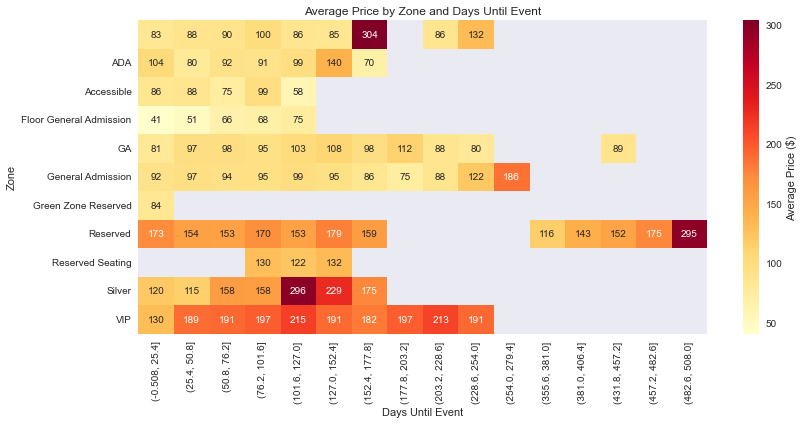

In [26]:
# Create pivot table for zone and days until event
pivot_data = df_clean.pivot_table(
    values='price',
    index='zone',
    columns=pd.cut(df_clean['days_until_event'], bins=20),
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Average Price ($)'})
plt.title('Average Price by Zone and Days Until Event')
plt.xlabel('Days Until Event')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()


We can see the highest prices occur further from the event 100 + days..


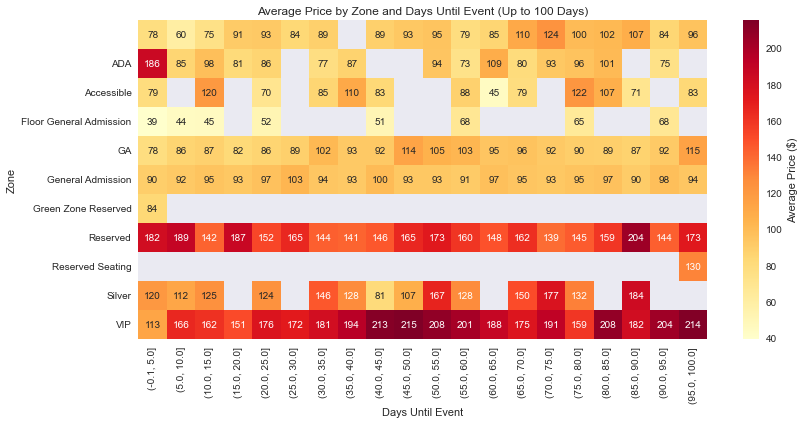

In [27]:
# Filter data to only show up to 100 days
df_filtered = df_clean[df_clean['days_until_event'] <= 100]

# Create pivot table for zone and days until event
pivot_data = df_filtered.pivot_table(
    values='price',
    index='zone',
    columns=pd.cut(df_filtered['days_until_event'], bins=20),
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Average Price ($)'})
plt.title('Average Price by Zone and Days Until Event (Up to 100 Days)')
plt.xlabel('Days Until Event')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

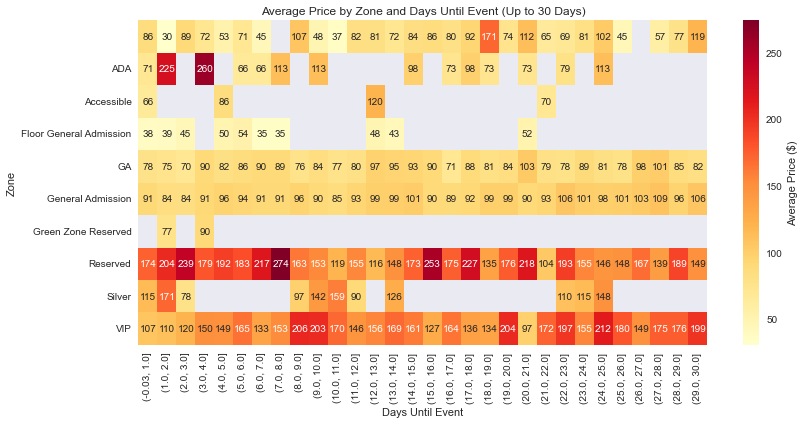

In [28]:
# Filter data to only show up to 30 days
df_filtered1 = df_clean[df_clean['days_until_event'] <= 30]

# Create pivot table for zone and days until event
pivot_data1 = df_filtered1.pivot_table(
    values='price',
    index='zone',
    columns=pd.cut(df_filtered1['days_until_event'], bins=30),
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data1, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Average Price ($)'})
plt.title('Average Price by Zone and Days Until Event (Up to 30 Days)')
plt.xlabel('Days Until Event')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

We can see for VIP packages they tend to trend down.
General Admission tends to drop as the concert comes closer before a last minute spike the day of.

In [29]:
# Print unique zones and their counts
print("Unique Zones and Counts:")
print(df_clean['zone'].value_counts())
print("\n")

# Print unique sections and their counts 
print("Unique Sections and Counts:")
print(df_clean['section'].value_counts())


Unique Zones and Counts:
General Admission          22041
GA                          5580
VIP                          917
Reserved                     377
                             181
ADA                           58
Silver                        44
Floor General Admission       41
Accessible                    25
Reserved Seating              14
Green Zone Reserved            2
Name: zone, dtype: int64


Unique Sections and Counts:
General Admission               21648
Floor General Admission          5620
Green Zone General Admission      854
NMRES                             158
Section 200                       139
Section 300                       126
Section 100                       122
ADA                                83
GA1                                79
GA4                                58
GA6                                57
GA3                                48
Zone                               44
Heineken Silver Zone               39
GA2                      

We can see the majority of tickets are General Admissission, GA or Floor. For the purpose of this project we will be focusing on them only.

In [41]:
# Filter for GA/General Admission tickets
ga_zones = ['GA', 'General Admission', 'Floor General Admission']
df_ga = df_clean[df_clean['zone'].isin(ga_zones)]

print("\nGA Tickets Dataset Info:")
print(df_ga.info())
print("\nVerify filtered zones:")
print(df_ga['zone'].value_counts())



GA Tickets Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27662 entries, 0 to 30359
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype                           
---  ------             --------------  -----                           
 0   timestamp          27662 non-null  object                          
 1   zone               27662 non-null  object                          
 2   section            27662 non-null  object                          
 3   row                196 non-null    float64                         
 4   quantity           27662 non-null  float64                         
 5   price              27662 non-null  float64                         
 6   event_date         27662 non-null  datetime64[ns, America/New_York]
 7   event_name         27662 non-null  object                          
 8   listing_time       27662 non-null  datetime64[ns, America/New_York]
 9   days_until_event   27662 non-null  int32                 

In [42]:
# Print sections for each GA zone
for zone in ga_zones:
    print(f"\nSections in {zone}:")
    sections = df_ga[df_ga['zone'] == zone]['section'].unique()
    print(sections)



Sections in GA:
['Floor General Admission' 'FLR']

Sections in General Admission:
['General Admission' 'GA4' 'GA1' 'GA' 'GA3' 'GA2' 'GRNZNE' 'GA4GA5' 'GA6'
 'GENERAL ADMISSION FLOOR' 'GENERAL ADMISSION' 'NMRES' 'GENERAL ADMISSON'
 'GA FLOOR' 'GA7' 'FLOOR GENERAL ADMISSION' 'general admission 1' 'GA5'
 'GA8']

Sections in Floor General Admission:
['Floor General Admission']


All of these seem to be variations of GA.


In [43]:
# Update sections containing 'GA' or 'general' to 'General Admission'
df_ga['section'] = df_ga['section'].str.lower()  # Convert to lowercase for case-insensitive matching
df_ga['section'] = df_ga['section'].apply(lambda x: 'General Admission' if ('ga' in str(x) or 'general' in str(x)) else x)

print("Updated Sections and Counts:")
print(df_ga['section'].value_counts())


Updated Sections and Counts:
General Admission    27501
nmres                  158
grnzne                   2
flr                      1
Name: section, dtype: int64


C:\Users\Dara\AppData\Local\Temp/ipykernel_19176/2033918462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['section'] = df_ga['section'].str.lower()  # Convert to lowercase for case-insensitive matching
C:\Users\Dara\AppData\Local\Temp/ipykernel_19176/2033918462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['section'] = df_ga['section'].apply(lambda x: 'General Admission' if ('ga' in str(x) or 'general' in str(x)) else x)


In [44]:
# Print unique event names for rows where section is 'nmres'
print("\nUnique events with 'nmres' section:")
print(df_ga[df_ga['section'] == 'nmres']['event_name'].unique())





Unique events with 'nmres' section:
['DonToliverwithBIA']


In [45]:
df_ga.loc[:, 'section'] = df_ga['section'].apply(lambda x: 'General Admission' if ('nmres' in str(x)) else x)

c:\Users\Dara\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [46]:
# Print unique event names for rows where section is 'nmres'
print("\nUnique events without GA section:")
print(df_ga[df_ga['section'] != 'General Admission']['event_name'].unique())

for zone in ga_zones:
    print(f"\nSections in {zone}:")
    sections = df_ga[df_ga['zone'] == zone]['section'].unique()
    print(sections)



Unique events without GA section:
['Devo' 'LocalNativesTimeWillWaitForNoOneTour']

Sections in GA:
['General Admission' 'flr']

Sections in General Admission:
['General Admission' 'grnzne']

Sections in Floor General Admission:
['General Admission']


In [47]:
# Update 'GA' to 'General Admission' in zone column
df_ga['zone'] = df_ga['zone'].str.lower()  # Convert to lowercase for case-insensitive matching
df_ga['zone'] = df_ga['zone'].apply(lambda x: 'general admission' if ('ga' in str(x)) else x)

# Remove tickets with 'Grnzone' section
df_ga = df_ga[df_ga['section'].str.lower() != 'grnzone']

print("\nZone value counts after updates:")
print(df_ga['zone'].value_counts())

print("\nConfirming Grnzone sections removed:")
print("Number of Grnzone tickets:", len(df_ga[df_ga['section'].str.lower() == 'grnzone']))



Zone value counts after updates:
general admission          27621
floor general admission       41
Name: zone, dtype: int64

Confirming Grnzone sections removed:
Number of Grnzone tickets: 0


C:\Users\Dara\AppData\Local\Temp/ipykernel_19176/3428949231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['zone'] = df_ga['zone'].str.lower()  # Convert to lowercase for case-insensitive matching
C:\Users\Dara\AppData\Local\Temp/ipykernel_19176/3428949231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['zone'] = df_ga['zone'].apply(lambda x: 'general admission' if ('ga' in str(x)) else x)


There was 2 Greenzone tickets so they were removed. Additionally we are left with 41 floor ga and the rest have been standardized.

In [48]:
# Get events with 'floor general admission' zone
floor_ga_events = df_ga[df_ga['zone'] == 'floor general admission']['event_name'].unique()

print("\nEvents with 'floor general admission' zone:")
print(floor_ga_events)

# For each floor GA event, print zones and sections
for event in floor_ga_events:
    print(f"\nZones and sections for event: {event}")
    event_data = df_ga[df_ga['event_name'] == event]
    print("\nUnique zones:")
    print(event_data['zone'].unique())
    print("\nUnique sections:")
    print(event_data['section'].unique())



Events with 'floor general admission' zone:
['FloggingMollyTheInterrupters' 'RufusWainwright']

Zones and sections for event: FloggingMollyTheInterrupters

Unique zones:
['floor general admission']

Unique sections:
['General Admission']

Zones and sections for event: RufusWainwright

Unique zones:
['floor general admission' 'general admission']

Unique sections:
['General Admission']


They both have general admission and as their is only 41 rows we will convert them as well.

In [49]:
df_ga['zone'] = df_ga['zone'].apply(lambda x: 'general admission' if ('floor general admission' in str(x)) else x)


In [50]:
# Add day of week and weekend indicator
df_ga["day_of_week"] = df_ga["event_date"].dt.dayofweek  # 0=Monday 
df_ga["is_weekend_event"] = df_ga["day_of_week"].isin([4,5,6]).astype(int)

# Add month and year features
df_ga["event_month"] = df_ga["event_date"].dt.month
df_ga["event_year"] = df_ga["event_date"].dt.year

print("\nNew date-based features added:")
print(df_ga[["event_date", "day_of_week", "is_weekend_event", "event_month", "event_year"]].head())



New date-based features added:
                 event_date  day_of_week  is_weekend_event  event_month  \
0 2022-07-12 00:00:00-04:00            1                 0            7   
1 2022-07-12 00:00:00-04:00            1                 0            7   
2 2022-07-12 00:00:00-04:00            1                 0            7   
5 2022-07-12 00:00:00-04:00            1                 0            7   
6 2022-07-12 00:00:00-04:00            1                 0            7   

   event_year  
0        2022  
1        2022  
2        2022  
5        2022  
6        2022  


Here we add temporal features for the day of the week, Whether its a weekend and Event month.

datetime64[ns, America/New_York]


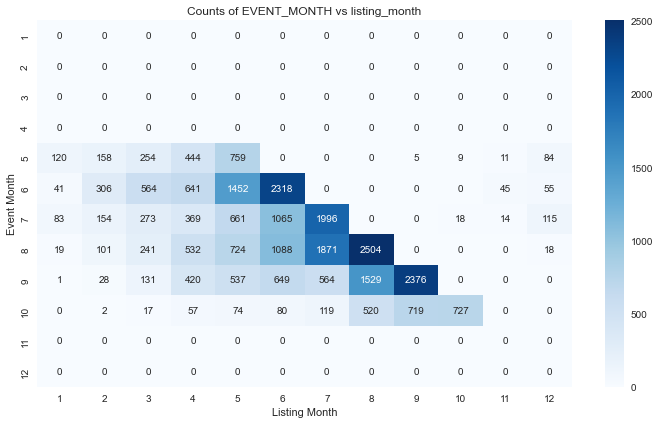

In [51]:
import pandas as pd

#df_ga = pd.read_csv('../data/processed/p17_ga_processed.csv')
df_ga['event_date'] = pd.to_datetime(df_ga['event_date'], errors='coerce')  # replace with your actual column name
df_ga['listing_time'] = pd.to_datetime(df_ga['listing_time'], errors='coerce')
print(df_ga['listing_time'].dtype)
df_ga['listing_month'] = df_ga['listing_time'].dt.month

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Ensure months are treated as ordered categorical values (1–12)
months = list(range(1, 13))  # or ['Jan', 'Feb', ..., 'Dec'] if using strings

df_ga['EVENT_MONTH'] = pd.Categorical(df_ga['event_month'], categories=months, ordered=True)
df_ga['listing_month'] = pd.Categorical(df_ga['listing_month'], categories=months, ordered=True)

# Create crosstab
heatmap_data = pd.crosstab(df_ga['event_month'], df_ga['listing_month'])
heatmap_data = heatmap_data.astype(int)
# Reindex rows and columns to include all months even if zero
heatmap_data = heatmap_data.reindex(index=months, columns=months, fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Counts of EVENT_MONTH vs listing_month')
plt.xlabel('Listing Month')
plt.ylabel('Event Month')
plt.tight_layout()
plt.show()




    We can see all events are held May-October.There is some listing data from the months before but most events tend to be announced pretty close to event date.

In [83]:
print("Sorted unique values in listing_month:")
print(sorted(df_ga['listing_month'].dropna().unique()))

print("\nSorted unique values in EVENT_MONTH:")
print(sorted(df_ga['EVENT_MONTH'].dropna().unique()))
print(df_ga.head())

Sorted unique values in listing_month:
[]

Sorted unique values in EVENT_MONTH:
[]
Empty DataFrame
Columns: [timestamp, zone, section, row, quantity, price, event_date, event_name, listing_time, days_until_event, hours_until_event, day_of_week, is_weekend_event, event_month, event_year, listing_month, EVENT_MONTH]
Index: []


In [73]:
# Save processed DataFrame to CSV
df_ga.to_csv('data/processed/p17_ga_processed.csv', index=False)
print("\nDataFrame saved to 'p17_ga_processed.csv'")


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/p17_ga_processed.csv'